In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import  LinearRegression, LassoCV, ElasticNetCV
import matplotlib.pyplot as plt
import seaborn as sns

# Modeles de prédiction

## Prédiction des ventes

### Prédiction avec le dataset de kaggle

In [2]:
# Importation du dataframe
df = pd.read_csv('vgsales.csv')

In [3]:
# Suppression des variables non utilisées et des lignes contenant des valeurs manquantes
df = df.drop(['Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Name'], axis = 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Platform      16291 non-null  object 
 1   Year          16291 non-null  float64
 2   Genre         16291 non-null  object 
 3   Publisher     16291 non-null  object 
 4   Global_Sales  16291 non-null  float64
dtypes: float64(2), object(3)
memory usage: 763.6+ KB


In [4]:
# Séparation de la variable cible et des features.
target = df['Global_Sales']
feats = df.drop('Global_Sales', axis = 1)

In [5]:
# Dichotomisation des variables catégorielles.
feats = feats.join(pd.get_dummies(feats[['Platform', 'Genre', 'Publisher']]))
feats = feats.drop(['Platform', 'Genre', 'Publisher'], axis = 1)

In [6]:
# Séparation en jeu d'entrainement et de test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=50)

In [7]:
# Standardisation des données

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1))[:, 0])
y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1))[:, 0])

In [8]:
# Selection des 150 meilleures features

# YANN : On peut ajouter une étude du score final selon le nombre de features retenu. On peut aussi essayer de comprendre 
# pourquoi certaines features ont plus d'importance que d'autres.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=150)

sk.fit(X_train, y_train)

feats.columns[sk.get_support()]

C:\Users\Claudio\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Index(['Year', 'Platform_2600', 'Platform_DC', 'Platform_DS', 'Platform_GB',
       'Platform_GBA', 'Platform_GC', 'Platform_GEN', 'Platform_N64',
       'Platform_NES',
       ...
       'Publisher_UEP Systems', 'Publisher_UFO Interactive',
       'Publisher_Universal Interactive', 'Publisher_Unknown',
       'Publisher_Vivendi Games',
       'Publisher_Warner Bros. Interactive Entertainment', 'Publisher_Yeti',
       'Publisher_Zoo Digital Publishing', 'Publisher_Zoo Games',
       'Publisher_Zushi Games'],
      dtype='object', length=150)

In [9]:
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

In [10]:
# Modèle de régression linéaire
model_lr = LinearRegression().fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_lr.score(sk_train, y_train))
y_pred_train = model_lr.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_lr.score(sk_test, y_test))
y_pred_test = model_lr.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.13606715324311702
0.00033346435589693313

R2 et RMSE pour l'ensemble test
0.11605156744888356
0.00022146759743973948


In [11]:
# Modélisation par ElasticNet 
model_en = ElasticNetCV(l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99),
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
                        cv=8).fit(sk_train, y_train)
print("Nombre de variables retenues: ", 
      len(model_en.coef_[model_en.coef_!=0]))
print("Nombre de variables éliminées: ",
      sk_train.shape[1]-len(model_en.coef_[model_en.coef_!=0]))

Nombre de variables retenues:  22
Nombre de variables éliminées:  128


In [12]:
print("alpha optimal: ", model_en.alpha_)
print("l1 ratio optimal: ", model_en.l1_ratio_)

alpha optimal:  0.001
l1 ratio optimal:  0.1


In [13]:
print("R2 et RMSE pour l'ensemble train")
print(model_en.score(sk_train, y_train))
y_pred_train = model_en.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_en.score(sk_test, y_test))
y_pred_test = model_en.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.10434051274608735
0.00034571033517394605

R2 et RMSE pour l'ensemble test
0.10775809059243946
0.00022354547475269296


In [14]:
# Modélisation Lasso
# YANN : peut-être redondant avec ElasticNet ?
alpha = [50, 25, 10,1,0.1, 0.05, 0.01 , 0.005 ,0.001, 0.0005, 0.0001]
model_las = LassoCV(alphas = alpha, cv=8)
model_las.fit(sk_train, y_train)

LassoCV(alphas=[50, 25, 10, 1, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        cv=8)

In [15]:
print("R2 et RMSE pour l'ensemble train")
print(model_las.score(sk_train, y_train))
y_pred_train = model_las.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_las.score(sk_test, y_test))
y_pred_test = model_las.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.10530788495196386
0.0003453369448684887

R2 et RMSE pour l'ensemble test
0.10793339322652695
0.00022350155380463025


In [16]:
# Modélisation par Voting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(sk_train, y_train))
y_pred_train = model_vot.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(sk_test, y_test))
y_pred_test = model_vot.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.36440367927510153
0.0002453300838098967

R2 et RMSE pour l'ensemble test
0.1559441078867042
0.00021147277787652828


### Prédiction avec le dataset mergé

In [17]:
# Importation du dataframe
df = pd.read_csv('df_merged.csv', index_col = 0)

In [18]:
# Suppression des variables non utilisées et des lignes contenant des valeurs manquantes
df = df.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Name'], axis = 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6808 entries, 0 to 6807
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Platform      6808 non-null   object 
 1   Year          6808 non-null   float64
 2   Genre         6808 non-null   object 
 3   Publisher     6808 non-null   object 
 4   Global_Sales  6808 non-null   float64
 5   rating        6808 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 372.3+ KB


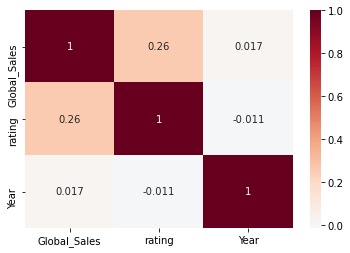

In [19]:
# Matrice de correlation
sns.heatmap(df[['Global_Sales','rating', 'Year']].corr(), center=0, annot=True, cmap='RdBu_r');

In [20]:
# Séparation de la variable cible et des features.
target = df['Global_Sales']
feats = df.drop('Global_Sales', axis = 1)

In [21]:
# Dichotomisation des variables catégorielles.
feats = feats.join(pd.get_dummies(feats[['Platform', 'Genre', 'Publisher']]))
feats = feats.drop(['Platform', 'Genre', 'Publisher'], axis = 1)

In [22]:
# Séparation en jeu d'entrainement et de test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=60)

In [23]:
# Standardisation des données

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1))[:, 0])
y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1))[:, 0])

In [24]:
# Selection des 150 meilleures features


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=150)

sk.fit(X_train, y_train)

feats.columns[sk.get_support()]

C:\Users\Claudio\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Index(['Year', 'rating', 'Platform_3DS', 'Platform_DC', 'Platform_DS',
       'Platform_GBA', 'Platform_GC', 'Platform_N64', 'Platform_PC',
       'Platform_PS',
       ...
       'Publisher_Ubisoft', 'Publisher_Ubisoft Annecy', 'Publisher_Unknown',
       'Publisher_Valve', 'Publisher_Virgin Interactive',
       'Publisher_Vivendi Games', 'Publisher_Wanadoo',
       'Publisher_Warner Bros. Interactive Entertainment',
       'Publisher_Zoo Digital Publishing', 'Publisher_Zoo Games'],
      dtype='object', length=150)

In [25]:
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

In [26]:
# Modèle de régression linéaire
model_lr = LinearRegression().fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_lr.score(sk_train, y_train))
y_pred_train = model_lr.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_lr.score(sk_test, y_test))
y_pred_test = model_lr.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.1744473092754797
0.0005052998137338455

R2 et RMSE pour l'ensemble test
0.18427833373738411
0.00031904791738381413


In [27]:
# Modélisation Lasso
alpha = [50, 25, 10,1,0.1, 0.05, 0.01 , 0.005 ,0.001, 0.0005, 0.0001]
model_las = LassoCV(alphas = alpha, cv=8)
model_las.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_las.score(sk_train, y_train))
y_pred_train = model_las.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_las.score(sk_test, y_test))
y_pred_test = model_las.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.15267414403078883
0.0005186266146348067

R2 et RMSE pour l'ensemble test
0.172331485632635
0.0003237206104907469


In [28]:
# Modélisation par Voting Classifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(sk_train, y_train))
y_pred_train = model_vot.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(sk_test, y_test))
y_pred_test = model_vot.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.5648140567459747
0.00026636625201095163

R2 et RMSE pour l'ensemble test
0.3574847531882758
0.0002513028154834272


## Prédiction des ventes au Japon

### Prédiction avec le dataset de kaggle

In [29]:
# Importation du dataframe
df = pd.read_csv('vgsales.csv')
df = df.drop(['Rank', 'Name'], axis = 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Platform      16291 non-null  object 
 1   Year          16291 non-null  float64
 2   Genre         16291 non-null  object 
 3   Publisher     16291 non-null  object 
 4   NA_Sales      16291 non-null  float64
 5   EU_Sales      16291 non-null  float64
 6   JP_Sales      16291 non-null  float64
 7   Other_Sales   16291 non-null  float64
 8   Global_Sales  16291 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.2+ MB


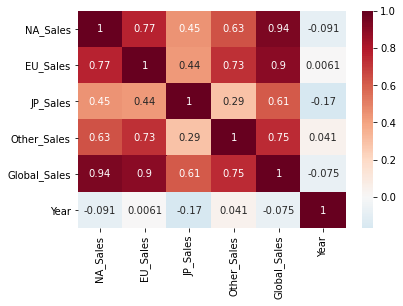

In [30]:
# Matrice de correlation
sns.heatmap(df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']].corr(), center=0, annot=True, cmap='RdBu_r');

In [31]:
# Séparation de la variable cible et des features.
target = df['JP_Sales']
feats = df.drop(['Global_Sales', 'JP_Sales'], axis = 1)

In [32]:
# Dichotomisation des variables catégorielles.
feats = feats.join(pd.get_dummies(feats[['Platform', 'Genre', 'Publisher']]))
feats = feats.drop(['Platform', 'Genre', 'Publisher'], axis = 1)

In [33]:
# Séparation en jeux d'entrainement et de test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=12)

In [34]:
# Standardisation des données

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1))[:, 0])
y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1))[:, 0])

In [35]:
# Selection des 150 meilleures features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=150)

sk.fit(X_train, y_train)

feats.columns[sk.get_support()]

sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

C:\Users\Claudio\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [36]:
# Modèle de régression linéaire
model_lr = LinearRegression().fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_lr.score(sk_train, y_train))
y_pred_train = model_lr.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_lr.score(sk_test, y_test))
y_pred_test = model_lr.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.4749854964537198
0.0008885021852726917

R2 et RMSE pour l'ensemble test
0.38538336591579436
0.001603918426844814


In [37]:
# Modélisation Lasso

alpha = [50, 25, 10,1,0.1, 0.05, 0.01 , 0.005 ,0.001, 0.0005, 0.0001]
model_las = LassoCV(alphas = alpha, cv=8)
model_las.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_las.score(sk_train, y_train))
y_pred_train = model_las.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_las.score(sk_test, y_test))
y_pred_test = model_las.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.4408670744893042
0.0009462420996344419

R2 et RMSE pour l'ensemble test
0.3764591160252455
0.0016272073651055674


In [38]:
# Modélisation par Voting Classifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(sk_train, y_train))
y_pred_train = model_vot.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(sk_test, y_test))
y_pred_test = model_vot.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.792131742820777
0.0003517834259911734

R2 et RMSE pour l'ensemble test
0.5845139568512476
0.0010842624226988012


### Prédiction avec le dataset mergé

In [39]:
# Importation du dataframe
df = pd.read_csv('df_merged.csv', index_col = 0)
df = df.drop(['Name'], axis = 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6808 entries, 0 to 6807
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Platform      6808 non-null   object 
 1   Year          6808 non-null   float64
 2   Genre         6808 non-null   object 
 3   Publisher     6808 non-null   object 
 4   NA_Sales      6808 non-null   float64
 5   EU_Sales      6808 non-null   float64
 6   JP_Sales      6808 non-null   float64
 7   Other_Sales   6808 non-null   float64
 8   Global_Sales  6808 non-null   float64
 9   rating        6808 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 585.1+ KB


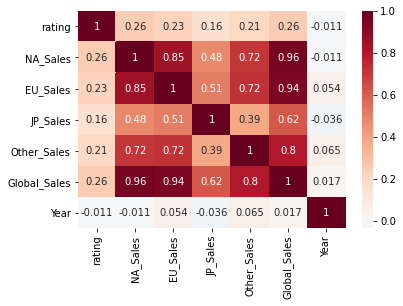

In [40]:
# Matrice de correlation
sns.heatmap(df[['rating', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']].corr(), center=0, annot=True, cmap='RdBu_r');

In [41]:
# Séparation de la variable cible et des features.

target = df['JP_Sales']
feats = df.drop(['Global_Sales', 'JP_Sales'], axis = 1)

In [42]:
# Dichotomisation des variables catégorielles.

feats = feats.join(pd.get_dummies(feats[['Platform', 'Genre', 'Publisher']]))
feats = feats.drop(['Platform', 'Genre', 'Publisher'], axis = 1)

In [43]:
# Séparation en jeux d'entrainement et de test.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test , i_train, i_test= train_test_split(feats, target, feats.index, test_size=0.2, random_state=12)

In [44]:
# Standardisation des données

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1))[:, 0])
y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1))[:, 0])

In [45]:
# Selection des 150 meilleures features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=150)

sk.fit(X_train, y_train)

feats.columns[sk.get_support()]

sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)


C:\Users\Claudio\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [46]:
# Modèle de régression linéaire
model_lr = LinearRegression().fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_lr.score(sk_train, y_train))
y_pred_train = model_lr.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_lr.score(sk_test, y_test))
y_pred_test = model_lr.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.4468528376358143
0.0014988794470902115

R2 et RMSE pour l'ensemble test
0.4057272214795513
0.0021711011709020706


In [47]:
# Modélisation Lasso

alpha = [50, 25, 10,1,0.1, 0.05, 0.01 , 0.005 ,0.001, 0.0005, 0.0001]
model_las = LassoCV(alphas = alpha, cv=8)
model_las.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_las.score(sk_train, y_train))
y_pred_train = model_las.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_las.score(sk_test, y_test))
y_pred_test = model_las.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.4314925424558518
0.0015405016993821365

R2 et RMSE pour l'ensemble test
0.42045261477828966
0.0021173037906611646


In [48]:
# Modélisation par Voting Classifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(sk_train, y_train))
y_pred_train = model_vot.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(sk_test, y_test))
y_pred_test = model_vot.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))

R2 et RMSE pour l'ensemble train
0.8109797844779159
0.0005121937441018282

R2 et RMSE pour l'ensemble test
0.6572894131498558
0.0012520502087330274


### Analyses des composantes principales (PCA)

In [49]:
from sklearn.preprocessing import LabelEncoder

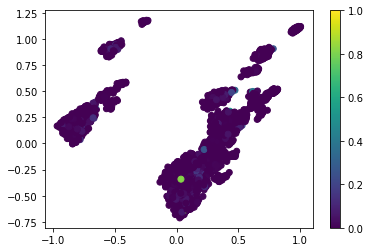

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
data_2D = pca.transform(X_train)

plt.scatter(data_2D[:,0], data_2D[:,1], c = y_train,);
plt.colorbar();

Il n'y a pas de séparation visible entre les ventes hautes (couleur claire) et basses. Les deux premières composantes sont donc insuffisantes pour prédire les ventes.

In [52]:
pca.components_.shape

(2, 293)

In [53]:
check = df.loc[i_train[X_train@pca.components_[0]<-0.2]]

In [54]:
check.head(20)

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,rating
5943,PS2,2005.0,Action,JoWood Productions,0.03,0.02,0.00,0.01,0.05,72
358,PS3,2010.0,Action,Ubisoft,1.87,0.57,0.11,0.30,2.84,90
779,Wii,2007.0,Action,Capcom,0.68,0.43,0.29,0.14,1.54,75
5153,XB,2006.0,Action,Activision,0.08,0.02,0.00,0.00,0.10,53
910,X360,2010.0,Action,Microsoft Game Studios,0.66,0.51,0.05,0.13,1.35,83
5249,PS,2000.0,Action,Sony Computer Entertainment,0.05,0.04,0.00,0.01,0.09,61
5020,DS,2008.0,Action,Takara Tomy,0.08,0.00,0.03,0.01,0.11,64
1193,X360,2010.0,Action,THQ,0.67,0.29,0.01,0.10,1.06,83
3000,X360,2006.0,Action,Microsoft Game Studios,0.27,0.02,0.02,0.03,0.34,56
1299,PS3,2013.0,Action,Ubisoft,0.34,0.41,0.06,0.18,0.98,84


In [55]:
check.Genre.value_counts()

Action       1227
Adventure       1
Name: Genre, dtype: int64

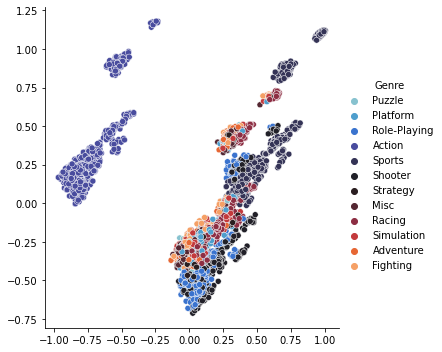

In [57]:

sns.relplot(x = data_2D[:,0], y = data_2D[:,1], hue = df.loc[i_train].Genre, kind = 'scatter', palette = 'icefire');

Text(0, 0.5, 'Explained variance ratio cumulative sum ')

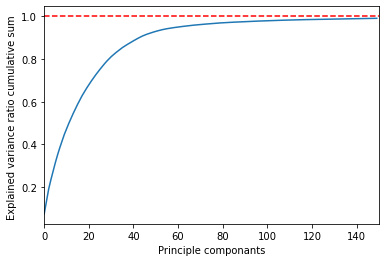

In [59]:
pca = PCA(n_components = 150)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure()
plt.xlim(0,150)
plt.axhline(y = 1, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.xlabel("Principle componants")
plt.ylabel("Explained variance ratio cumulative sum ")

In [ ]:
# Modélisation par Voting Classifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(X_train_pca, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(X_train_pca, y_train))
y_pred_train = model_vot.predict(X_train_pca) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(X_test_pca, y_test))
y_pred_test = model_vot.predict(X_test_pca) 
print(mean_squared_error(y_pred_test, y_test))

On voit qu'avec une transformation PCA de 150 composantes, on améliore pas le score. Cela justifie l'utilisation de skBest.

In [ ]:
pca = PCA(n_components = 50)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(X_train_pca, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(X_train_pca, y_train))
y_pred_train = model_vot.predict(X_train_pca) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(X_test_pca, y_test))
y_pred_test = model_vot.predict(X_test_pca) 
print(mean_squared_error(y_pred_test, y_test))

Le PCA à 50 composantes donne un moins bon score. De plus l'entrainement du modèle est plus long qu'avec skBest à 150 composantes.

### Prédiction sans Other_Sales

In [ ]:
# Séparation de la variable cible et des features.

target = df['JP_Sales']
feats = df.drop(['Global_Sales', 'JP_Sales', 'Other_Sales'], axis = 1)

In [ ]:
# Dichotomisation des variables catégorielles.

feats = feats.join(pd.get_dummies(feats[['Platform', 'Genre', 'Publisher']]))
feats = feats.drop(['Platform', 'Genre', 'Publisher'], axis = 1)

In [ ]:
# Séparation en jeux d'entrainement et de test.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=12)

In [ ]:
# Standardisation des données

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1))[:, 0])
y_test = pd.Series(scaler.transform(y_test.values.reshape(-1, 1))[:, 0])

In [ ]:
# Selection des 150 meilleures features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=150)

sk.fit(X_train, y_train)

feats.columns[sk.get_support()]

sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

In [ ]:
# Modélisation par Voting Classifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
model_vot = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model_vot = model_vot.fit(sk_train, y_train)

print("R2 et RMSE pour l'ensemble train")
print(model_vot.score(sk_train, y_train))
y_pred_train = model_vot.predict(sk_train) 
print(mean_squared_error(y_pred_train, y_train))

print("\nR2 et RMSE pour l'ensemble test")
print(model_vot.score(sk_test, y_test))
y_pred_test = model_vot.predict(sk_test) 
print(mean_squared_error(y_pred_test, y_test))